# Ames Iowa House Price Prediction - NYCDSA ML Bootcamp Project

*Importing some of the required modules, packages and libraries

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns

### Importing train and test datasets

In [117]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Train and Test datasets sizes:
Excluding <font color="brown">Id</font> and <font color="brown">SalePrice</font> columns:
* The train dataset has **1460** observations and **79** features 
* The test dataset has **1459** observations and **79** features

**There are the same number of features in both datasets**

In [118]:
# Datasets sizes
print('Train data has {} observations and {} features'.format(train.shape[0], (train.shape[1]-1)))
print('Train data has {} observations and {} features'.format(test.shape[0], test.shape[1]))

Train data has 1460 observations and 80 features
Train data has 1459 observations and 80 features


### Id column
* This column is necessary for Kaggle submissions, but it is not a house feature. I store the <font color="brown">Id</font> column for later use and drop the column from the dataframe I use for the modeling and prediction. 

In [119]:
# Saving Id column
train_id = train.Id
test_id = test.Id

# Droping Id column
train.drop('Id', inplace=True, axis=1)
test.drop('Id', inplace=True, axis=1)

 ## Exploratory Data Analysis

### Missingness

In [120]:
# Joint the train and test datasets to get an overall idea of the missingness
train_num = train.shape[0]
test_num = test.shape[0]
data = pd.concat((train, test), sort=False).reset_index(drop=True)
print('Dataset size: {}'.format(data.shape))

Dataset size: (2919, 80)


In [121]:
'''Creating a function named "missing" to tabulate missing values per feature (count & percentage)
        
        Parameters:
            data: complete dataset - i.e. train + test
            train: Index of the last training observation. This is used to split the data back to the original train and test datasets
            sort: Column to sort by. Default "Percent_Total".
            max_rows: Parameter to set the max number of rows to display on the output dataframe
        
        returns:
            Pandas Dataframe: 
                Columns:
                    Feature: Feature name
                    n_total: Total number of missing values for a given feature in both, training and test, datasets
                    pct_total: Percentage of missing values for a given feature in both, training and test, datasets
                    n_train: Number of missing values for a given feature in the training dataset
                    pct_train: Percentage of missing values for a given feature in the training dataset
                    n_test: Number of missing values for a given feature in the test dataset
                    pct_test: Percentage of missing values for a given feature in the test dataset
                    train_test_pct_diff: Difference in percetange between train and test for a give feature
'''

def missing(data, train_n, sort = 'pct_total', max_rows = 4000):
    
    # Setting pandas display options to show all rows
    pd.options.display.max_rows = max_rows 

    # Creating a mask (True/False values) with missing values as True
    mask_total = data.isnull().sum().to_numpy().nonzero()
    mask_train = data[:train_n].isnull().sum().to_numpy().nonzero()
    mask_test = data[train_n:].isnull().sum().to_numpy().nonzero()
    # Number of rows to calculate percentage
    rows_total = data.shape[0]
    rows_train = train_n
    rows_test = rows_total - rows_train
    
    # Creating dataframes of features and missing values count (n) & percentage (pct)
    missing_total = pd.DataFrame(data.isnull().sum().iloc[mask_total]).reset_index()
    missing_total.columns = ['Feature', 'n_total']
    missing_total['pct_total'] = missing_total.n_total.apply(lambda x: x*100/rows_total)
     
    missing_train = pd.DataFrame(data[:train_n].isnull().sum().iloc[mask_train]).reset_index()
    missing_train.columns = ['Feature', 'n_train']
    missing_train['pct_train'] = missing_train.n_train.apply(lambda x: x*100/rows_train)
       
    missing_test = pd.DataFrame(data[train_n:].isnull().sum().iloc[mask_test]).reset_index()
    missing_test.columns = ['Feature', 'n_test']
    missing_test['pct_test'] = missing_test.n_test.apply(lambda x: x*100/rows_test)
    
    # Merging the train, test and total missing dataframes
    missing = pd.merge(missing_total, missing_train, on='Feature')
    missing = pd.merge(missing, missing_test, on='Feature')
    
    # Calculating the difference between pct_trian and pct_test. 
    # A large difference will indicate inbalance between train and test datasets 
    missing['train_test_pct_diff'] = missing['pct_train'] - missing['pct_test']
    
    # Reordering the columns
    columns_order = ['Feature', 'n_train', 'n_test', 'n_total', 'pct_train', 'pct_test', 'pct_total', 'train_test_pct_diff'] 
    
    # returning the merged dataframe sorted by the "sort" parameter
    return missing[columns_order].sort_values(by=sort, ascending=False)

In [122]:
missing(data=data, train_n=train_num)

,Feature,n_train,n_test,n_total,pct_train,pct_test,pct_total,train_test_pct_diff
15,PoolQC,1453,1456,2909,99.520548,99.794380,99.657417,-0.273832
17,MiscFeature,1406,1408,2814,96.301370,96.504455,96.402878,-0.203085
1,Alley,1369,1352,2721,93.767123,92.666210,93.216855,1.100914
16,Fence,1179,1169,2348,80.753425,80.123372,80.438506,0.630052
9,FireplaceQu,690,730,1420,47.260274,50.034270,48.646797,-2.773996
0,LotFrontage,259,227,486,17.739726,15.558602,16.649538,2.181124
11,GarageYrBlt,81,78,159,5.547945,5.346127,5.447071,0.201818
12,GarageFinish,81,78,159,5.547945,5.346127,5.447071,0.201818
13,GarageQual,81,78,159,5.547945,5.346127,5.447071,0.201818
14,GarageCond,81,78,159,5.547945,5.346127,5.447071,0.201818


Features with more than **20%** missingness:
* <font color="brown">PoolQC</font>, <font color="brown">MiscFeature</font>, <font color="brown">Alley</font>, <font color="brown">Fence</font> and <font color="brown">FireplaceQu</font> have high (>20%) missingness. Based on the dataset description we can assumed the missingness is caused by the absence of the feature in the given house - i.e. where PoolQC is missing means that the house doesn't have a pool. In these cases, the missing value (NaN) could be imputed as "None".  

Features with more than **10%** missingness:
* <font color="brown">LotFrontage</font> has more than 10% missigness. Based on the data description, LotFrontage is the linear feet of the street connected to the property. This feature is probably not missing at random and it might be worth exploring different imputation methods (e.g. using SVM to predict LotFrontage as described in [this](https://www.kaggle.com/ogakulov/lotfrontage-fill-in-missing-values-house-prices) kaggle notebook). I decided, for simplicity, to use the median value of the neighborhood to impute the missing values. 

Features with less than **10%** missingness:
* The rest of the features with missingness have less than 10%. These group of features have a mix of reasons for the missigness, some have missingnes where the house don't have a particular feature (e.g. FireplaceQu in a house without fireplace) and others seem to have values not missing at random. Below are the different imputation methods used. 

#### Missingness - Categorical features

In [123]:
# Imputing "None" for missing values in features where missigness implies not applicable
none_lst = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish',
           'GarageQual', 'GarageCond', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
for feature in none_lst:
    data[feature] = data[feature].fillna('None')

In [124]:
""" 
The categorical features in the list below apply to all houses,therefore 'None' should not be used to impute the missing values.
I use the mode to impute the missing values on these features.
"""
mode_lst = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 
            'Exterior2nd', 'SaleType', 'Functional', 'Utilities']
for feature in mode_lst:
    data[feature] = data[feature].fillna(data[feature].mode()[0])

#### Missigness - Numerical features

In [125]:
# Using neighborhood median LotFrontage to impute missing values 
data.LotFrontage = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [126]:
# Imputing missing values with zero value 
zero_lst = ['MasVnrArea', 'GarageArea', 'GarageYrBlt', 'GarageCars',
           'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
           'BsmtFullBath', 'BsmtHalfBath']
for feature in zero_lst:
    data[feature] = data[feature].fillna(0)

#### Missingness on the target variable
* No observations with missing house sale price

In [127]:
### Target variable is named SalePrice in the dataset
target = train.SalePrice

In [128]:
target_missing = target.isnull().sum() 
print('{} missing values'.format(target_missing))

0 missing values


#### Examining missingness after imputation

In [129]:
data.isnull().sum().loc[data.isnull().sum()>0]

SalePrice    1459
dtype: int64

* Only SalePrice has missing values, which in this case the missing values correspond to the _test_ dataset that doesn't have SalePrice.  

### EDA & Feature Engineering

#### <font color=brown>SalePrice</font> distribution
* As can be seen below, the target variable (<font color=brown>SalePrice</font>), has a long right tail - i.e. it is right skewed 
* Performing the [Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) normality test confirms that <font color=brown>SalePrice</font> is not normally distributed. 
* The probaility plot highlights how the <font color=brown>SalePrice</font> distribution deviates from normality

[Text(0, 0.5, 'Probability Density'), Text(0.5, 0, 'Lot Area (sq.ft.)')]

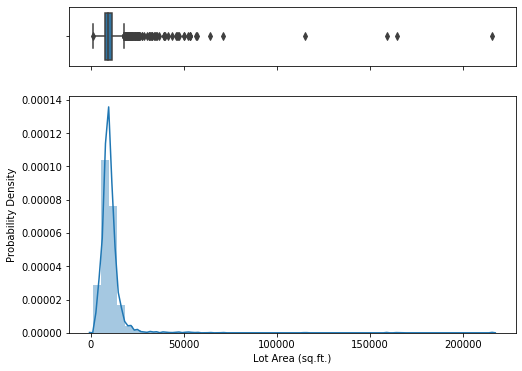

In [130]:
# Importing Seaborn and pyplot libraries for ploting a histogram and boxplot togeher
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={"height_ratios": (.2, .8)}, figsize=(8,6))
sns.boxplot(data.LotArea, ax=ax[0])
sns.distplot(data.LotArea, ax=ax[1])
ax[0].set(xlabel='') # Removing the x-axis title from the boxplot
ax[1].set(xlabel='Lot Area (sq.ft.)', ylabel='Probability Density')

In [131]:
# Importing stats module from Scipy
from scipy import stats

# Performing Shapiro-Wilk normallity test to determine if target (SalePrice) is normally distributed
shapiro = stats.shapiro(target) # This function returns a tuple: (test-statistic, p-value)
print('Test statistic: {}'.format(shapiro[0]))
print('p-value: {}'.format(shapiro[1]))

Test statistic: 0.869671642780304
p-value: 3.206247534576162e-33


- Small p-value (below 0.05) confirms that <font color=brown>SalePrice</font> **is not normally distributed**

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

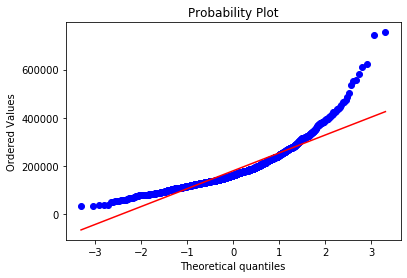

In [132]:
# The probabilty plot below highlights how SalePrice deviates from normality
stats.probplot(target, plot=plt)

#### <font color=brown>SalePrice</font> is assumed log-normally distributed
* As mentioned in the bootcamp lectures <font color=brown>SalePrice</font> is assumed log-normal
* Below I use the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test to determine is the assumption is correct
* Kolmogorov-Smirnov test p-value is below 0.05, which could be interpreted as that the data is not log-normally distributed. But when we comparare KS p-value when testing for a **log-normal** distribution (p-value = 0.015) versus KS p-value when testing for **normal** distribution (p-value = 6.4e-20), <font color=brown>SalePrice</font> is much closer to be log-normally distributed than it is normally distributed.  

In [133]:
# Performing Kolmogorov-Smimov test to check if SalePrice is log-normal distributed
ks_test_norm = stats.kstest(target, "norm", stats.norm.fit(target))
ks_test_lg = stats.kstest(target, "lognorm", stats.lognorm.fit(target))

print('KS (normal) t-statistic: {}'.format(ks_test_norm[0]))
print('KS (normal) p-value: {}'.format(ks_test_norm[1]))
print('KS (log-normal) t-statistic: {}'.format(ks_test_lg[0]))
print('KS (log-normal) p-value: {}'.format(ks_test_lg[1]))

KS (normal) t-statistic: 0.12366990729158056
KS (normal) p-value: 6.402139779190053e-20
KS (log-normal) t-statistic: 0.040898917784028654
KS (log-normal) p-value: 0.014705247778226238


#### Transforming <font color=brown>SalePrice</font> with Box-Cox power trasnformation
* I decided to apply a [Box Cox transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation) to make the data more normal distribution-like
* After the power transformation the data is close to be normally distributed

In [134]:
# BoxCox transformation to make the data more normal distribution-like
target_bc, lmbda = stats.boxcox(target) # boxcox funtion returns the transformed data and the powere parameter lambda 
print('Box-Cox power parameter (lambda): {:.1}'.format(lmbda))

# Performing Shapiro-Wilk normality test on the transformed data
shapiro_bc = stats.shapiro(target_bc) # This function returns a tuple: (test-statistic, p-value)
print('Shapiro Test statistic: {}'.format(shapiro_bc[0]))
print('Shapiro p-value: {}'.format(shapiro_bc[1]))

Box-Cox power parameter (lambda): -0.08
Shapiro Test statistic: 0.9915341138839722
Shapiro p-value: 1.906367685933219e-07


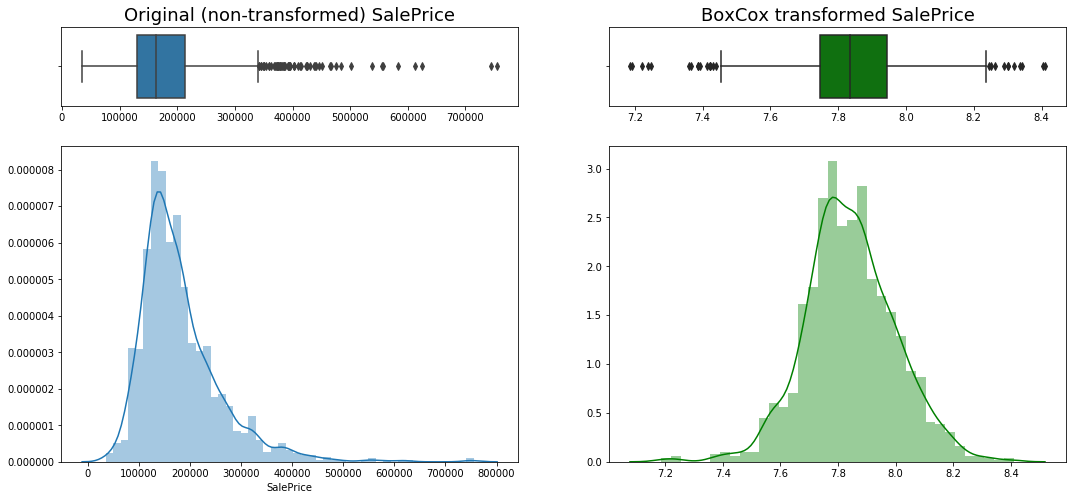

In [135]:
# Plotting the non-transformed and transformed data
fig, ax = plt.subplots(2,2, gridspec_kw={"height_ratios": (.2, .8)}, figsize=(18,8))

# Original (non-transformed) data
sns.boxplot(target, ax=ax[0,0]).set_title("Original (non-transformed) SalePrice", fontsize=18)
sns.distplot(target, ax=ax[1,0])
ax[0,0].set(xlabel='') # Removing the x-axis title from the boxplot

# Transformed data
sns.boxplot(target_bc, color="g", ax=ax[0,1]).set_title("BoxCox transformed SalePrice", fontsize=18)
sns.distplot(target_bc, color="g", ax=ax[1,1])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([7.18570211, 7.19093599, 7.22246733, ..., 8.34295923, 8.40545244,
         8.41016236])),
 (0.15781082127181648, 7.842252009506654, 0.9955315707916028))

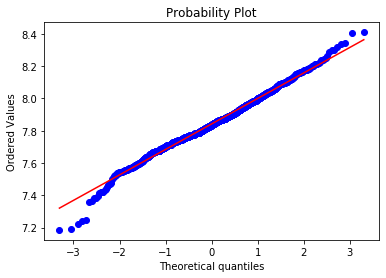

In [136]:
# The probabilty plot below shows how SalePrice is closer to normality after the transformation
stats.probplot(target_bc, plot=plt)

### <font color=brown>SalePrice</font> evolution over time
* Since the data was collected between 2006 and 2010 it is important to explore the evolution of house prices during the 2008-2009 US house market crisis. 

In [137]:
salePrice_bc = pd.DataFrame(target_bc, columns=['SalePrice_bc'])
yr_mo_price = data[:train_num][['YrSold', 'MoSold', 'SalePrice']]
yr_mo_price = pd.merge(yr_mo_price, salePrice_bc, left_index=True, right_index=True)
yr_mo_price.head()

,YrSold,MoSold,SalePrice,SalePrice_bc
0,2008,2,208500.0,7.932610
1,2007,5,181500.0,7.878263
2,2008,9,223500.0,7.959618
3,2006,2,140000.0,7.774955
4,2008,12,250000.0,8.002875


[Text(0, 0.5, 'Probability density'), Text(0.5, 0, 'Sale Price')]

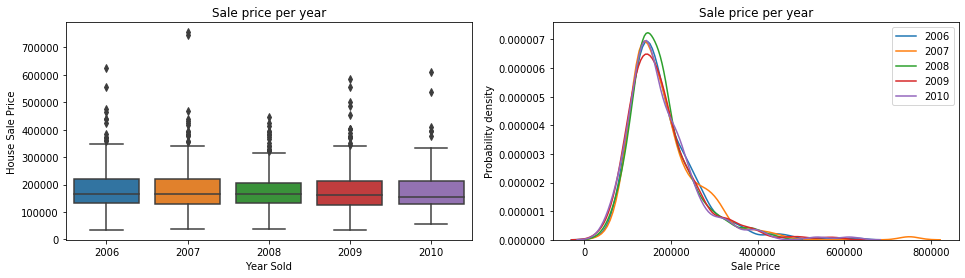

In [138]:
# Plotting house prices per year using both a boxplot and distribution plot
f, ax = plt.subplots(1,2, figsize=(16,4))
sns.boxplot(x='YrSold', y='SalePrice', ax=ax[0], data=yr_mo_price)
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2006].SalePrice, hist = False, label='2006', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2007].SalePrice,hist = False, label='2007', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2008].SalePrice, hist = False,label='2008', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2009].SalePrice, hist = False,label='2009', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2010].SalePrice, hist = False,label='2010', ax=ax[1])

ax[0].set_title('Sale price per year', fontsize=12)
ax[0].set(ylabel='House Sale Price', xlabel='Year Sold' )
ax[1].set_title('Sale price per year', fontsize=12)
ax[1].set(ylabel='Probability density', xlabel='Sale Price' )

* Looking at the overall training dataset, there is not evidence of a significant shift during the crisis. 
* A similar conclusion can be drawn from examining <font color=brown>SalePrice</font> after the boxcox transformation

[Text(0, 0.5, 'Probability density'), Text(0.5, 0, 'Sale Price')]

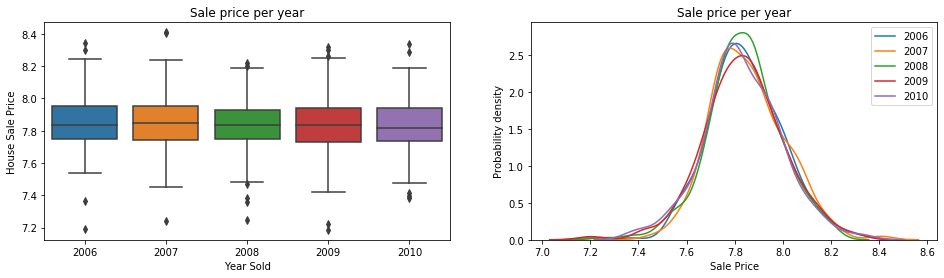

In [139]:
f, ax = plt.subplots(1,2, figsize=(16,4))
sns.boxplot(x='YrSold', y='SalePrice_bc', ax=ax[0], data=yr_mo_price)
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2006].SalePrice_bc, hist = False, label='2006', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2007].SalePrice_bc,hist = False, label='2007', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2008].SalePrice_bc, hist = False,label='2008', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2009].SalePrice_bc, hist = False,label='2009', ax=ax[1])
sns.distplot(yr_mo_price.loc[yr_mo_price.YrSold==2010].SalePrice_bc, hist = False,label='2010', ax=ax[1])

ax[0].set_title('Sale price per year', fontsize=12)
ax[0].set(ylabel='House Sale Price', xlabel='Year Sold' )
ax[1].set_title('Sale price per year', fontsize=12)
ax[1].set(ylabel='Probability density', xlabel='Sale Price' )

* To further examine the evolution of house prices during the 2006-2010 period I plotted the distributions of _sale price_ vs _year_ by neighborhood. Some [publications](https://www.rieti.go.jp/jp/publications/dp/11e019.pdf) have reported that the crisis did not affected all house markets (neighborhoods) in the same way. 
* It is interesting to see that in some neighborhoods, such as "CollgCr", the sale price distributions are very similar during the studied timeframe. On the other hand, neighborhoods such as "NoRidge" show distintive changes in the distribution over the 2006-2010 years. Unfortunatelly, the number of observations per neighborhood is pretty limited and it is not possible to conclude if the differences observed are due to real changes in real estate or lack of enough samples in the dataset. 

C:\Users\valdesk\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\valdesk\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


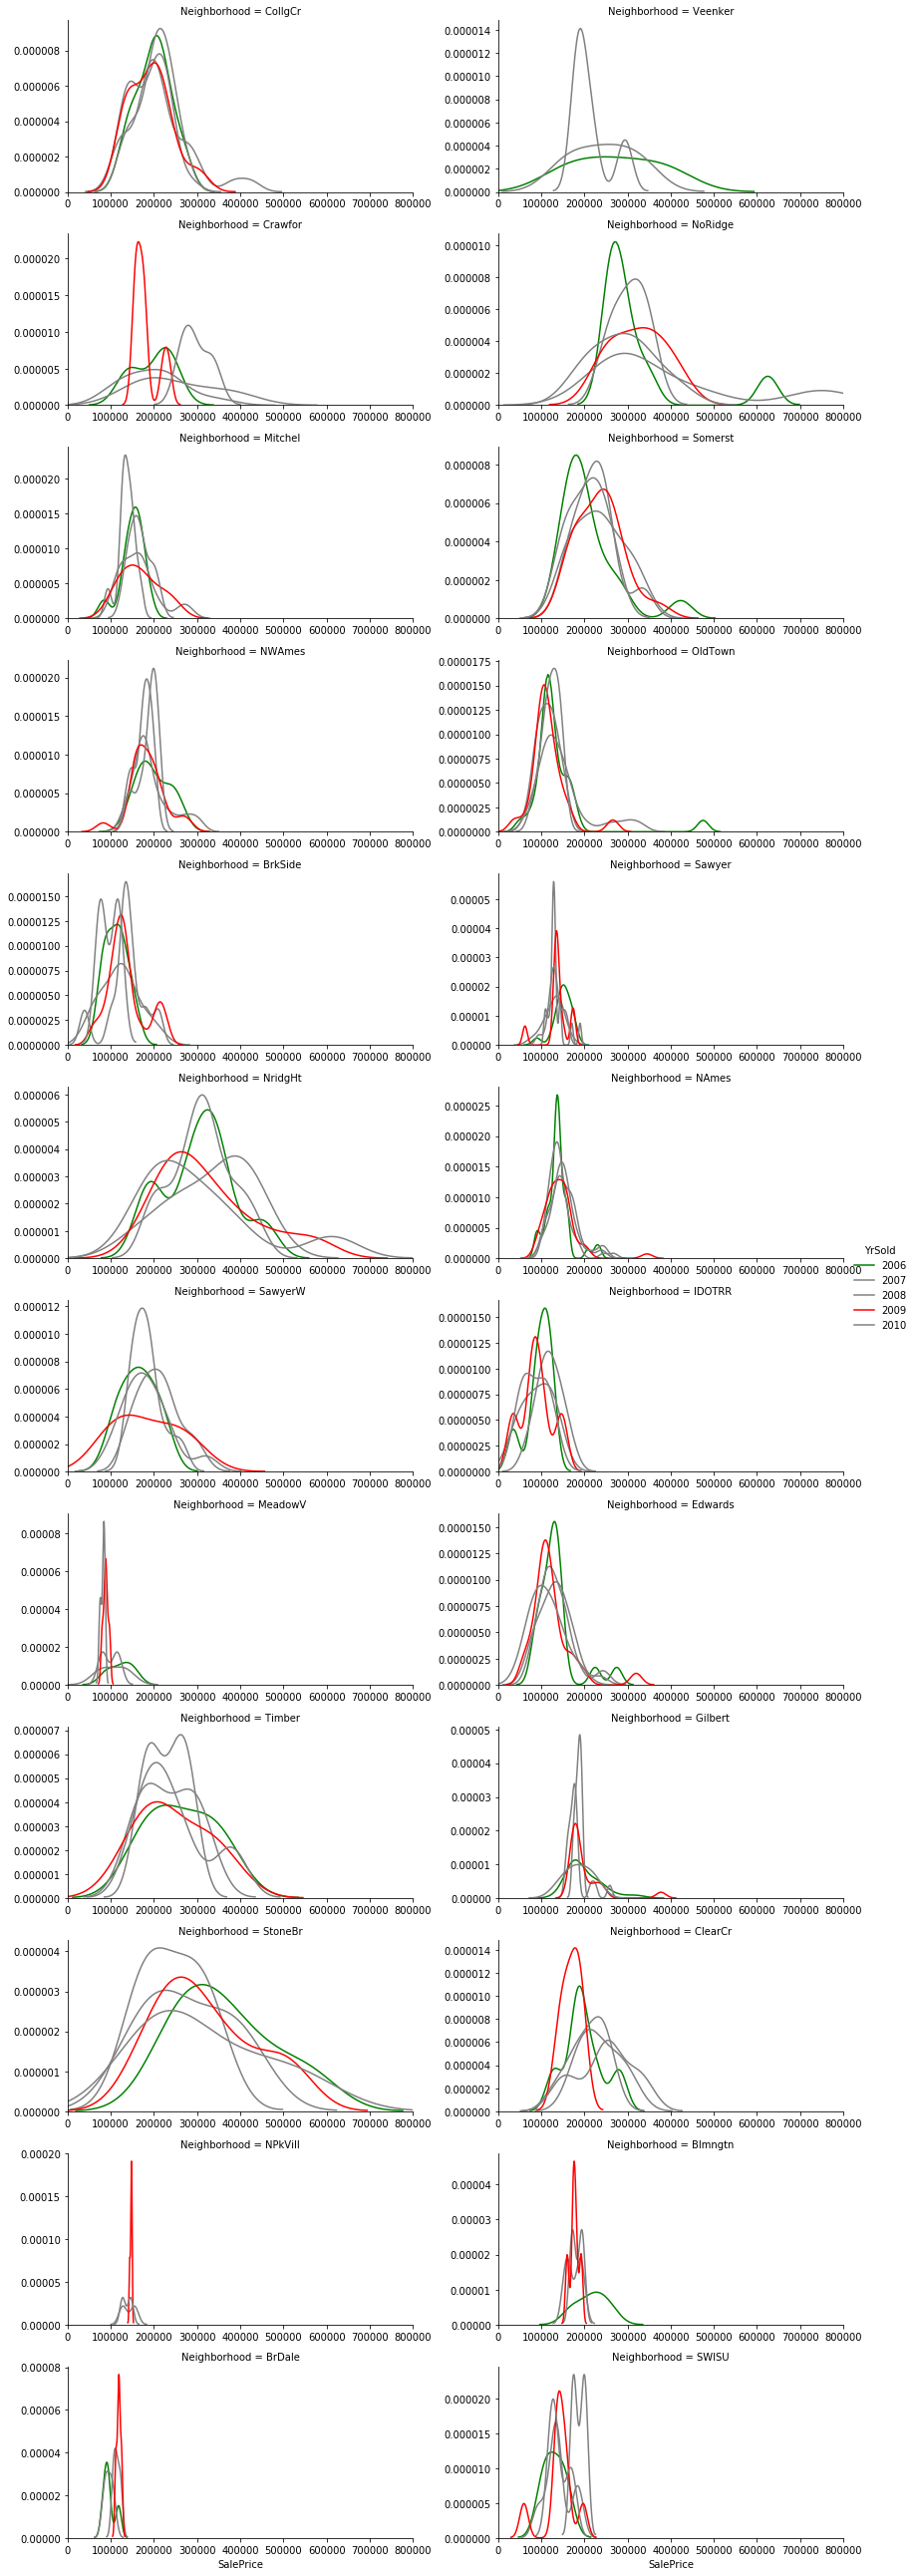

In [140]:
nhoods_price = data[:train_num][['Neighborhood','YrSold', 'SalePrice']]
nhoods_price = nhoods_price.loc[nhoods_price.Neighborhood!='Blueste']
grid = sns.FacetGrid(nhoods_price, col="Neighborhood", hue='YrSold', palette=['g', 'gray', 'gray', 'r', 'gray'],
                     col_wrap=2,xlim=(0,800000), sharey=False,sharex=False, height=3, aspect=2)
grid.map(sns.distplot, 'SalePrice', hist=False).add_legend()  

#### Creating new features
* <font color="brown">TotalArea</font>: Based on the literature house prices are strongly determined by the total square footage of the property. I created a feature that totals the basement (<font color="brown">TotalBsmtSF</font>), first floor (<font color="brown">1stFlrSF</font>) and second floor (<font color="brown">2ndFlrSF</font>) square footage.
* <font color="brown">UseSF</font>: In addition to total square footage, the usable square footage of the property is another feature that will affect the value of the property.
* <font color="brown">BuyersMkt</font>: Property value is also affected by demand. I created a feature that based on the number of properties sold in a given month takes a value of _zero_ if it is a high demand month (i.e. a sellers market) and a value of _one_ if the demand is low for that month (i.e. a buyers market). I used as a threshold for low/high demand the average number of sales per month. 
* <font color="brown">AbnormalSale</font>: Property value can be affected by the condition of the sale of other properties in the same neighborhood - e.g. houses in foreclosure will affect the value of other houses in the same neighborhood. <font color="brown">AbnormalSale</font> feature takes a value of _zero_ if no houses in the same neighborhood were sold in abnormal condition and a value of _one_ if such there were abnormal sales. This feature is calculated for a given year & month. 

In [141]:
# Total square footage of the property
data['TotalArea'] = data.TotalBsmtSF + data['1stFlrSF'] + data['2ndFlrSF']

In [142]:
# Usable square footage of the property
data['UseSF'] = data.BsmtFinSF1 + data.GrLivArea

**Note:** To calculate the low/high demand threshold I decided to average the number sales per month, but examining the number of sales per year it can be noticed that in 2010 much less houses were sold than any of the previous years. A year on year comparison of sales per month reveals that during June and July of 2010 the dataset has less sold houses that the typical number for those two months. For this reason I decided to exclude this two months when calculating threshold - i.e. the average number of houses sold per month.  

In [143]:
# Creating a new dataframe for aggregate based on Year Sold. 
year_price = data.groupby(['YrSold'])['SalePrice'].agg(['count', 'mean', 'std']).reset_index()
year_price.YrSold = year_price.YrSold.astype(str)
year_price

,YrSold,count,mean,std
0,2006,314,182549.458599,79426.838855
1,2007,329,186063.151976,85768.171410
2,2008,304,177360.838816,69735.610685
3,2009,338,179432.103550,80879.237311
4,2010,175,177393.674286,80451.280085


In [144]:
# Creating another dataframe for plotting year on year comparison of number of houses sold per month
year_month = data.groupby(['YrSold','MoSold'])['SalePrice'].agg(['count', 'mean', 'std']).reset_index()
year_month['YrSold'] = year_month['YrSold'].astype(str)

[Text(0, 0.5, 'Number of Sales'), Text(0.5, 0, 'Month Sold')]

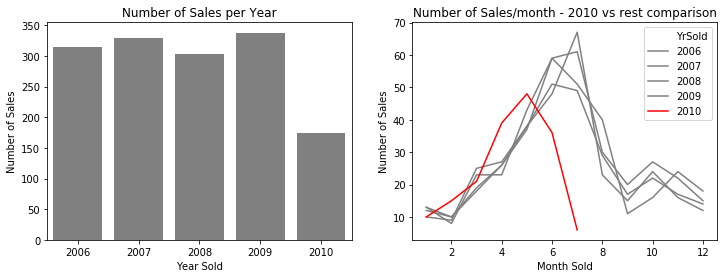

In [145]:
f, ax = plt.subplots(1,2, figsize=(12,4))

# Year vs number of houses sold
sns.barplot(x=year_price.YrSold, y=year_price['count'], color = 'grey', ax=ax[0])
# Month vs number of houses sold 2010 vs rest comparison
sns.lineplot(x='MoSold', y='count', hue='YrSold', palette=["gray", "gray", 'gray', 'gray', 'r'], ax=ax[1], data=year_month)
# Axis formatting
ax[0].set_title('Number of Sales per Year', fontsize=12)
ax[1].set_title('Number of Sales/month - 2010 vs rest comparison', fontsize=12)
ax[0].set(ylabel='Number of Sales', xlabel='Year Sold')
ax[1].set(ylabel='Number of Sales', xlabel='Month Sold')

In [146]:
# buyers market feature - excluding June and July from the avg. calculation .
buyers_mkt = data.loc[((data.MoSold!=6) &  (data.YrSold!=2010)) | ((data.MoSold!=7)&  (data.YrSold!=2010))].groupby('MoSold')['SalePrice'].count().reset_index()
buyers_mkt.columns = ['Month', 'Number_of_Sales']
buyers_mkt

,Month,Number_of_Sales
0,1,48
1,2,37
2,3,85
3,4,102
4,5,156
5,6,217
6,7,228
7,8,122
8,9,63
9,10,89


In [147]:
# Calculating the average monthly number of houses sold to define the buyers vs sellers threshold 
mean_n_sold = round(buyers_mkt['Number_of_Sales'].mean(), ndigits=0)
print('The average number of houses sold monthly is {}'.format(mean_n_sold))

The average number of houses sold monthly is 107.0


Text(8, 95, 'market threshold')

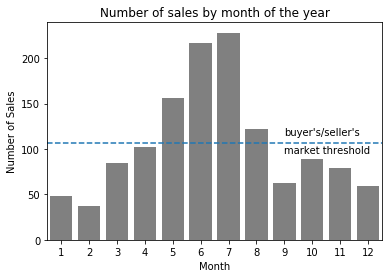

In [148]:
# Plotting the number of sales per month as an indication of the demand. 
ax = sns.barplot(x=buyers_mkt.Month, y=buyers_mkt.Number_of_Sales, color='gray')
ax.set_title("Number of sales by month of the year", fontsize=12)
ax.set(xlabel='Month', ylabel='Number of Sales') # Removing the x-axis title from the boxplot
ax.axhline(mean_n_sold, ls='--')
ax.text(8,115, "buyer's/seller's")
ax.text(8,95, "market threshold")

In [149]:
# Creating the BuyersMkt feature
for i in range(1,13):
    if i in [1, 2, 3, 4, 9, 10,11, 12]:
        data.loc[data.MoSold==i, 'BuyersMkt'] = 1
    else:
        data.loc[data.MoSold==i, 'BuyersMkt'] = 0

#### <font color='brown'>AbnormalSale</font> feature

In [150]:
sale_abn = data.groupby(['YrSold', 'MoSold', 'Neighborhood', 'SaleCondition'])['SalePrice'].agg('count').reset_index()
sale_abn = sale_abn.rename(columns = {'SalePrice': 'AbnormalSale'})
sale_abn = sale_abn.loc[(sale_abn.SaleCondition=='Abnorml') & (sale_abn.AbnormalSale!=0)].drop('SaleCondition', axis=1)
data = pd.merge(data, sale_abn, how='left', on=['YrSold', 'MoSold', 'Neighborhood'])
data.AbnormalSale = data.AbnormalSale.fillna(0)

In [151]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalArea,UseSF,BuyersMkt,AbnormalSale
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,208500.0,2566.0,2416.0,1.0,0.0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,181500.0,2524.0,2240.0,0.0,0.0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,223500.0,2706.0,2272.0,1.0,0.0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,2,2006,WD,Abnorml,140000.0,2473.0,1933.0,1.0,1.0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,12,2008,WD,Normal,250000.0,3343.0,2853.0,1.0,0.0


#### Droping features
* After running the models the features below were not relevant, so I decided to drop them

In [152]:
# Droping PoolQC, MiscFeature, Alley and Fence becuase of the high missingness and not being relevant to the models
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Utilities'], inplace=True, axis=1)

#### Converting to string features that seem numerical, but are categorical

In [153]:
num_to_cat_lst = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for feature in num_to_cat_lst:
    data[feature] = data[feature].astype(str)

#### Label encoding categorial variables

In [154]:
#'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'
from sklearn.preprocessing import LabelEncoder
label_lst = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
             'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 
             'BsmtFinType1', 'BsmtFinType2', 'Functional', 
             'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 
             'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 
             'OverallCond', 'YrSold', 'MoSold']
for feature in label_lst:
    label = LabelEncoder()
    label.fit(list(data[feature].values))
    data[feature] = label.transform(list(data[feature].values))
data.shape

(2919, 78)

#### Skewness and data transformation
* Some of the features had significant skewness. Below I calculate the skewness and transform all the features with more than 0.75 (absolute value). 

In [155]:
from scipy.stats import norm, skew

features_num = data.dtypes[data.dtypes!='object'].index
features_skew = data[features_num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness':features_skew})
skewness

,Skewness
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [156]:
skewness_bc = skewness[abs(skewness.Skewness)>0.75]
skewness_bc.shape

(39, 1)

* The function boxcox can only be applied to values that are strictly positive, but some of the values in the dataset were zero. 
* boxcox1p allows for zero values to be transformed by adding 1 to each value and then performing the transformation. 

In [157]:
# Boxcox transformation to reduce skewness
from scipy.special import boxcox1p
for feature in skewness_bc.index:
    data[feature] = boxcox1p(data[feature], 0.15)

* Below I dummified the remaining categorial features 

In [158]:
data = pd.get_dummies(data)
data.shape

(2919, 216)

* Looking at the statistical summary of the dataset below, it can be noticed that the scales among the features vary significantly. It is a common practice to scale the data, so features with a larger scale don't dominate the model (see overview of feature scaling [here](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)). 
* I used sklearn [Robust Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) as it is a scaler that is less sensitive to outliers. Features such as <font color='brown'>LotFrontage</font> and <font color='brown'>LotArea</font> have outlier observations.  

In [159]:
data.describe()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,7.134293,5.878542,19.493789,0.727460,1.947585,0.037827,6.089072,4.564577,1971.312778,1984.264474,...,0.002741,0.081877,0.002398,0.865365,0.065091,0.004111,0.008222,0.015759,0.822885,0.083933
std,3.698608,0.605130,1.978472,0.046747,1.409721,0.171017,1.409947,1.113131,30.291442,20.894344,...,0.052289,0.274225,0.048920,0.341392,0.246728,0.063996,0.090317,0.124562,0.381832,0.277335
min,0.000000,3.932510,12.878993,0.000000,0.000000,0.000000,1.000000,0.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.684507,18.742199,0.730463,0.000000,0.000000,5.000000,4.000000,1953.500000,1965.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,5.000000,5.968981,19.651224,0.730463,3.000000,0.000000,6.000000,4.000000,1973.000000,1993.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,10.000000,6.221214,20.461120,0.730463,3.000000,0.000000,7.000000,5.000000,2001.000000,2004.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,15.000000,9.125735,35.391371,0.730463,3.000000,1.194318,10.000000,8.000000,2010.000000,2010.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [160]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(data)
data_ = transformer.transform(data) 

In [161]:
data = pd.DataFrame(data_, columns=data.columns)
data.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,-0.256476,-0.255417,0.0,0.0,0.0,0.5,0.0,0.631579,0.256410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.469964,0.035476,0.0,0.0,0.0,0.0,3.0,0.063158,-0.435897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.100689,0.404915,0.0,-1.0,0.0,0.5,0.0,0.589474,0.230769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.2,-0.530036,0.023462,0.0,-1.0,0.0,0.5,0.0,-1.221053,-0.589744,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
4,1.0,0.644214,0.973829,0.0,-1.0,0.0,1.0,0.0,0.568421,0.179487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Splitting the complete dataset back into the original train and test datasets

In [162]:
train = data[:train_num].drop('SalePrice', axis=1)
test = data[train_num:].drop('SalePrice', axis=1)

## Modeling

* I decided to use **Lasso**, **Ridge**, **Random Forest** and **Gradient Boosting** to predict the <font color='brown'>SalePrice</font> target variable. 
* The choice of models was based on my personal interest in further developing my understanding of these models and the time constraint of the project itself. Other models such as _Light Support Vector Machine_ or _Light Gradient Boosting_ were out of the scope of my current learning goals. I decided to invest more time on _feature engineering_ at the expense of trying a wider variety of models. 
* I opted for simple model stacking and did not venture into more advanced model ensembling for similar reasons to the choice of models - i.e. interest in diving deeper into feature engineering, learning the fundamentals models and the time constraint of the project. 
* Once submitted, I hope to continue to add tools (models and ensembling methods) to the notebook. 

In [163]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

''' For Lasso and Ridge linear models I created a function to measure model performance. For a given number of iterations
the function creates a new train/test split that gets fitted and scored. The average performance is calculated at the end of the
iterations and returned as dataframe. 
        Parameters:
            models: model to fit the data
            train: train features
            target: target data
            iterations: Number of iterations. A larger number of iterations should return a more representative 
            train and test error.  
        Returns:
            dataframe with train and test error. 

'''

def model_performance2(models, train,target, iterations=100):
    performance = {}
    r2_train = []
    r2_test = []
    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(train, target,random_state=i, test_size=0.3)
        r2_train.append(1- metrics.r2_score(y_train, models.fit(X_train, y_train).predict(X_train)))
        r2_test.append(1- metrics.r2_score(y_test, models.fit(X_train, y_train).predict(X_test)))
    performance['Model'] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame.from_dict(performance, orient='index', columns=('Train_error', 'Test_error'))

In [164]:
''' Function to visualize Lasso and Ridge coefficients for a given range of alphas. The visualization is an aid to narrow down 
the range for GridSearch. It also logs the R^2 score for each alpha for plotting as well. 
        Parameters:
            model: Lasso or Ridge model
            features: train features
            alphas: alpha range
            normalize: True or False. If True, Lasso and Ridge normalization will be set to True.  
        Returns: 
            coefs: Regression coefficients for each lambda
            scores_train: R^2 scores for the training split
            scores_test: R^2 scores for the testing split
'''
def alpha_viz(model,features, target, alphas, normalize=True):
    model.set_params(normalize=normalize)
    coefs  = []
    scores_train = []
    scores_test = []
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
    for alpha in alphas:
            model.set_params(alpha=alpha)
            model.fit(X_train, y_train)  
            coefs.append(model.coef_)
            scores_train.append(model.score(X_train, y_train))
            scores_test.append(model.score(X_test, y_test))
    coefs = pd.DataFrame(coefs, index = alphas, columns = features.columns)  
    
    return coefs, scores_train, scores_test

#### Function to generate individual models csv submission file for Kaggle

In [165]:
''' Function to submit a single model prediction. I created this function to quickly create submissions and check progress. This
is not the function I used for the final submision (stacked models). 
        Parameters: 
            model: Estimator to use for predictions
            model_name: Model name (string) to use for the file name.
        Returns:
            None: It generates a csv file with the ID column and SalePrice prediction. 
            
'''
def sub(model, model_name):
    from scipy import special
    salePrice = model.fit(train, target_bc).predict(test.values)
    sub = pd.DataFrame()
    sub['Id'] = test_id
    # Applying inverse transformation to SalePrice
    sub['SalePrice'] = special.inv_boxcox(salePrice, lmbda)
    sub.to_csv(''.join(['submission', model_name, '.csv']), index=False)
    return

In [166]:
X_train, X_test, y_train, y_test = train_test_split(train, target_bc, test_size=0.2)

### Lasso

In [167]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [168]:
lasso = Lasso(max_iter=100000)

In [169]:
alpha_range = np.arange(0.00001,0.0001,0.00001)
cfs, score_train, score_test = alpha_viz(lasso, train, target_bc, alphas=alpha_range)

Text(0, 0.5, 'Slope Values')

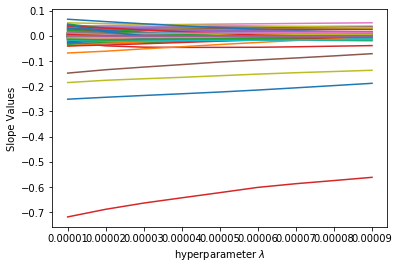

In [170]:
plt.plot(alpha_range, cfs)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'Slope Values')

Text(0, 0.5, 'R^2')

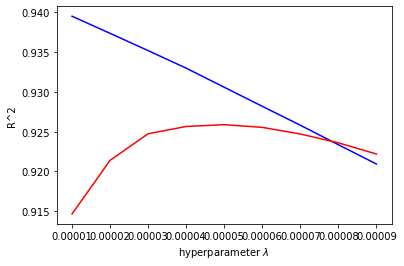

In [171]:
plt.plot(alpha_range, score_train, color='b')
plt.plot(alpha_range, score_test, color='r')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'R^2')

In [172]:
df = pd.DataFrame(alpha_range, columns=['Alpha'])
df['score_train'] = score_train
df['score_test'] = score_test
df

,Alpha,score_train,score_test
0,0.00001,0.939520,0.914660
1,0.00002,0.937370,0.921398
2,0.00003,0.935199,0.924741
3,0.00004,0.932992,0.925657
4,0.00005,0.930590,0.925885
5,0.00006,0.928193,0.925544
6,0.00007,0.925815,0.924710
7,0.00008,0.923364,0.923601
8,0.00009,0.920936,0.922193


In [173]:
train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=215)

In [225]:
lasso_params = {'alpha': np.arange(0.00001,0.0001,0.00001)}
%time lasso_cv = GridSearchCV(lasso, param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5).fit(train.drop(['TotalArea', 'BuyersMkt', 'AbnormalSale'], axis=1), target_bc).best_estimator_
model_performance2(lasso_cv, train, target_bc)

Wall time: 1.72 s


,Train_error,Test_error
Model,0.06212,0.106602


In [175]:
sub(lasso_cv, 'lass_cv_none')

In [176]:
# Lasso estimator parameters
lasso_cv

Lasso(alpha=4e-05, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [177]:
# Coefficient values for each feature
coefs = pd.DataFrame(list(zip(train.columns,lasso_cv.coef_)), columns=['Feature','Coefficient'])
coefs['coefs_abs'] = coefs.Coefficient.apply(lambda x: abs(x))
coefs.sort_values('coefs_abs', ascending=False).reset_index().drop('index', axis=1)

,Feature,Coefficient,coefs_abs
0,RoofMatl_ClyTile,-0.631244,0.631244
1,Condition2_PosN,-0.224541,0.224541
2,MSZoning_C (all),-0.141725,0.141725
3,Exterior1st_BrkComm,-0.058009,0.058009
4,Heating_Grav,-0.046964,0.046964
5,KitchenAbvGr,-0.044010,0.044010
6,OverallQual,0.043540,0.043540
7,Neighborhood_Crawfor,0.038513,0.038513
8,TotalArea,0.034997,0.034997
9,UseSF,0.031435,0.031435


## Ridge

In [178]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge = Ridge(max_iter=100000)

In [179]:
alpha_range_ridge = np.arange(1,20,1)
cfs_ridge, score_train_ridge, score_test_ridge = alpha_viz(ridge,train, target_bc, alphas=alpha_range_ridge)

Text(0, 0.5, 'Slope Values')

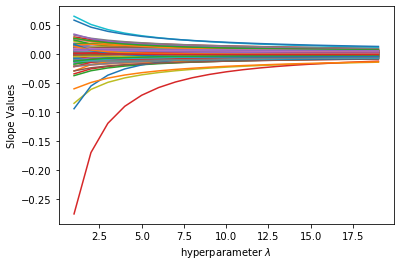

In [180]:
plt.plot(alpha_range_ridge, cfs_ridge)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'Slope Values')

Text(0, 0.5, 'R^2')

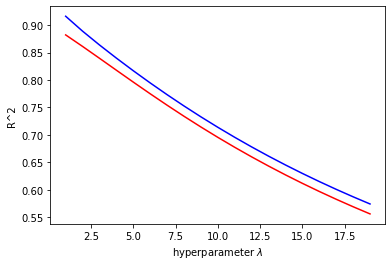

In [181]:
plt.plot(alpha_range_ridge, score_train_ridge, color='b')
plt.plot(alpha_range_ridge, score_test_ridge, color='r')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'R^2')

In [220]:
ridge_params = {'alpha': np.arange(11,13,0.01)}
%time ridge_cv = GridSearchCV(ridge, param_grid=ridge_params,scoring='neg_mean_squared_error', cv=5).fit(train, target_bc).best_estimator_
model_performance2(ridge_cv, train, target_bc)

Wall time: 17.4 s


,Train_error,Test_error
Model,0.302482,0.316038


In [183]:
sub(ridge_cv, 'rdige_all')

In [184]:
# Ridge estimator parameters
ridge_cv

Ridge(alpha=11.0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [185]:
# Coefficient values for each feature
coefs = pd.DataFrame(list(zip(train.columns, ridge_cv.coef_)), columns=['Feature','Coefficient'])
coefs['coefs_abs'] = coefs.Coefficient.apply(lambda x: abs(x))
coefs.sort_values('coefs_abs', ascending=False).reset_index().drop('index', axis=1)

,Feature,Coefficient,coefs_abs
0,RoofMatl_ClyTile,-0.026972,0.026972
1,MSZoning_C (all),-0.021126,0.021126
2,Electrical_Mix,-0.019754,0.019754
3,Exterior1st_BrkComm,-0.018685,0.018685
4,Condition2_PosA,0.018489,0.018489
5,RoofMatl_WdShngl,0.016108,0.016108
6,Heating_Grav,-0.016019,0.016019
7,Heating_Floor,-0.014134,0.014134
8,CentralAir,0.013065,0.013065
9,Neighborhood_NoRidge,0.011774,0.011774


### ElasticNet

In [219]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(max_iter = 100000)
enet_params = {'alpha': [0.00009, 12],
              'l1_ratio': np.arange(0.1,1, 0.1)}
%time enet_cv = GridSearchCV(enet, param_grid=enet_params,scoring='neg_mean_squared_error', cv=5).fit(train, target_bc).best_estimator_
model_performance2(enet_cv, train, target_bc)

Wall time: 15.7 s


,Train_error,Test_error
Model,0.058327,0.108358


In [187]:
sub(enet_cv, 'enet')

In [188]:
enet_cv

ElasticNet(alpha=9e-05, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### Random Forest

In [189]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

* Decided to use **RandomizeGridSearchCV** instead of **GridSearchCV** to find the hyperparameters faster. 

In [190]:
# Using RandomizeGridSearch instead of GridSearchCV to find the hyperparameters faster
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5000, stop = 15000, num = 10)]

# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(40, 160, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Out-Of-Bag error
oob_score = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [191]:
# Fit the random search model
%time rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.3min
C:\Users\valdesk\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 73.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 173.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 237.7min finished


Wall time: 3h 58min 57s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [192]:
print(rf_random.score(X_train, y_train)) 
print(rf_random.score(X_test, y_test)) 

0.9983481520895202
0.8844967863909434


In [193]:
rf_random.best_params_

{'n_estimators': 7222,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 53,
 'max_depth': 50,
 'bootstrap': False}

In [194]:
rf.set_params(n_estimators=11666,
              min_samples_split=5, 
              min_samples_leaf=1, 
              max_features=40, 
              max_depth=70, 
              bootstrap=False)
rf.fit(X_train, y_train)
print(rf_random.score(X_train, y_train))
print(rf_random.score(X_test, y_test))

0.9983481520895202
0.8844967863909434


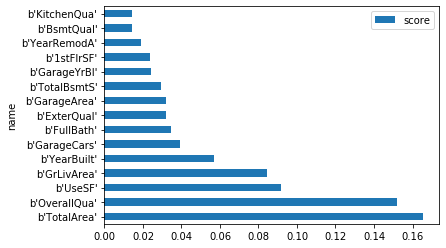

In [195]:
# Code taken from the lecture code to plot feature importnace of the random forest estimator
feature_importance = list(zip(X_train.columns[:-2], rf.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.barh(x='name', y='score')

In [196]:
sub(rf_random, 'randomF')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.8min
C:\Users\valdesk\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 96.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 235.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 336.6min finished


### Extreme Gradient Boosting

In [197]:
import xgboost as xgb

def modelfit(model, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(predictors.values, label=target)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds, 
                          metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model.fit(predictors, target,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = model.predict(predictors)
    
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(target, dtrain_predictions)))
    
                    
    xgb.plot_importance(model, max_num_features=10)
    plt.rcParams['figure.figsize'] = [20,12]
    plt.show()


Model Report
RMSE : 0.01231


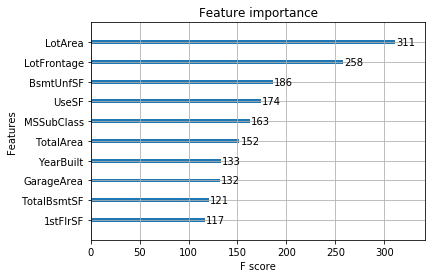

In [198]:
# XGB estimator with a initial set of hyperparameters
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# Benchmark of the pre-tune model
modelfit(xgb1, train, target_bc)

In [199]:
# Creating DMatrices objects for the train and test splits
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

* To tune XGB hyperparameters I tuned two parameters at a time.

In [227]:
# Creating a parameter dictionary. Later to be used in GridSearch
params = {
    # Parameters to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [228]:
# Setting the evaluation metric to RMSE, which is what Kaggle uses
params['eval_metric'] = 'rmse'
# Number of boots rounds, or equivalently the number of trees to build
num_boost_round = 999

In [229]:
# Model with default parameters
model = xgb.train(params, 
                  dtrain, 
                  num_boost_round=num_boost_round,
                 evals=[(dtest, 'Test')],
                 early_stopping_rounds=50)

[0]	Test-rmse:5.13644
Will train until Test-rmse hasn't improved in 50 rounds.
[1]	Test-rmse:3.59586
[2]	Test-rmse:2.51778
[3]	Test-rmse:1.76486
[4]	Test-rmse:1.23548
[5]	Test-rmse:0.86584
[6]	Test-rmse:0.60765
[7]	Test-rmse:0.42794
[8]	Test-rmse:0.30354
[9]	Test-rmse:0.21888
[10]	Test-rmse:0.16082
[11]	Test-rmse:0.12206
[12]	Test-rmse:0.09710
[13]	Test-rmse:0.08134
[14]	Test-rmse:0.07139
[15]	Test-rmse:0.06605
[16]	Test-rmse:0.06314
[17]	Test-rmse:0.06175
[18]	Test-rmse:0.06044
[19]	Test-rmse:0.05942
[20]	Test-rmse:0.05868
[21]	Test-rmse:0.05828
[22]	Test-rmse:0.05787
[23]	Test-rmse:0.05723
[24]	Test-rmse:0.05700
[25]	Test-rmse:0.05727
[26]	Test-rmse:0.05717
[27]	Test-rmse:0.05710
[28]	Test-rmse:0.05693
[29]	Test-rmse:0.05663
[30]	Test-rmse:0.05650
[31]	Test-rmse:0.05641
[32]	Test-rmse:0.05636
[33]	Test-rmse:0.05621
[34]	Test-rmse:0.05616
[35]	Test-rmse:0.05609
[36]	Test-rmse:0.05596
[37]	Test-rmse:0.05592
[38]	Test-rmse:0.05589
[39]	Test-rmse:0.05596
[40]	Test-rmse:0.05598
[41]	Test-

In [230]:
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best RMSE: 0.06 with 47 rounds


In [231]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=50
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5.145607,0.001649,5.145586,0.010180
1,3.605408,0.001149,3.605383,0.010664
2,2.527558,0.000798,2.527528,0.010991
3,1.772952,0.000552,1.773189,0.009495
4,1.244621,0.000379,1.244556,0.007977
5,0.874819,0.000256,0.874511,0.007242
6,0.615938,0.000146,0.615873,0.005825
7,0.434783,0.000111,0.435506,0.005350
8,0.308036,0.000143,0.309136,0.005196
9,0.219483,0.000174,0.222256,0.004730


In [232]:
# Tunning max_peht and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,11,1)
    for min_child_weight in range(1,20, 1)
]

In [233]:
# Setting the parameters based on the optimal found
params['max_depth'] = 4
params['min_child_weight'] = 12

In [234]:
min_rmse = float("Inf")
best_params = None

In [235]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [236]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0


C:\Users\valdesk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	RMSE 0.0540134 for 105 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 0.0555742 for 64 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 0.05632859999999999 for 72 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 0.0559408 for 73 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 0.05489200000000001 for 72 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 0.0552326 for 46 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 0.05422199999999999 for 99 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 0.05581839999999999 for 84 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 0.056755200000000006 for 70 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 0.0559828 for 77 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 0.0545362 for 58 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 0.055349 for 56 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 0.0565168 for 88 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 0.057414 for 32 rounds
CV with subsample=0.7, colsample=0.8
	RMSE 0.0559

In [237]:
# Setting the parameters based on the optimal found
params['subsample'] = 0.9
params['colsample_bytree'] = 1.0

In [238]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(params,
                        dtrain,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=5,
                        metrics=['rmse'],
                        early_stopping_rounds=50)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns


C:\Users\valdesk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	RMSE 0.054639799999999995 for 120 rounds

CV with eta=0.2
Wall time: 0 ns
	RMSE 0.0543034 for 232 rounds

CV with eta=0.1
Wall time: 0 ns
	RMSE 0.0519508 for 300 rounds

CV with eta=0.05
Wall time: 0 ns
	RMSE 0.0514304 for 697 rounds

CV with eta=0.01
Wall time: 0 ns
	RMSE 0.052635999999999995 for 998 rounds

CV with eta=0.005
Wall time: 0 ns
	RMSE 0.0762392 for 998 rounds

Best params: 0.05, RMSE: 0.0514304


In [239]:
# Setting the parameters based on the optimal found
params['eta'] = 0.5

In [240]:
# Close to optimal parameters
params

{'max_depth': 4,
 'min_child_weight': 12,
 'eta': 0.5,
 'subsample': 0.9,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [241]:
# Determining the number of boost rounds
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:3.67001
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:1.83533
[2]	Test-rmse:0.92035
[3]	Test-rmse:0.46276
[4]	Test-rmse:0.23955
[5]	Test-rmse:0.13294
[6]	Test-rmse:0.08851
[7]	Test-rmse:0.07241
[8]	Test-rmse:0.06700
[9]	Test-rmse:0.06635
[10]	Test-rmse:0.06404
[11]	Test-rmse:0.06370
[12]	Test-rmse:0.06148
[13]	Test-rmse:0.06103
[14]	Test-rmse:0.06037
[15]	Test-rmse:0.06064
[16]	Test-rmse:0.06034
[17]	Test-rmse:0.06050
[18]	Test-rmse:0.06001
[19]	Test-rmse:0.05963
[20]	Test-rmse:0.05980
[21]	Test-rmse:0.05953
[22]	Test-rmse:0.05928
[23]	Test-rmse:0.05900
[24]	Test-rmse:0.05895
[25]	Test-rmse:0.05846
[26]	Test-rmse:0.05842
[27]	Test-rmse:0.05814
[28]	Test-rmse:0.05789
[29]	Test-rmse:0.05864
[30]	Test-rmse:0.05841
[31]	Test-rmse:0.05838
[32]	Test-rmse:0.05822
[33]	Test-rmse:0.05796
[34]	Test-rmse:0.05760
[35]	Test-rmse:0.05751
[36]	Test-rmse:0.05752
[37]	Test-rmse:0.05751
[38]	Test-rmse:0.05754
[39]	Test-rmse:0.05765
[40]	Test-rmse:0.05758
[41]	Test-

In [242]:
# DMatrices for prediction
dtrain_ = xgb.DMatrix(train, label=target_bc)
dtest_ = xgb.DMatrix(test)

In [243]:
# Final model for submission
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:3.67001
[1]	Test-rmse:1.83533
[2]	Test-rmse:0.92035
[3]	Test-rmse:0.46276
[4]	Test-rmse:0.23955
[5]	Test-rmse:0.13294
[6]	Test-rmse:0.08851
[7]	Test-rmse:0.07241
[8]	Test-rmse:0.06700
[9]	Test-rmse:0.06635
[10]	Test-rmse:0.06404
[11]	Test-rmse:0.06370
[12]	Test-rmse:0.06148
[13]	Test-rmse:0.06103
[14]	Test-rmse:0.06037
[15]	Test-rmse:0.06064
[16]	Test-rmse:0.06034
[17]	Test-rmse:0.06050
[18]	Test-rmse:0.06001
[19]	Test-rmse:0.05963
[20]	Test-rmse:0.05980
[21]	Test-rmse:0.05953
[22]	Test-rmse:0.05928
[23]	Test-rmse:0.05900
[24]	Test-rmse:0.05895
[25]	Test-rmse:0.05846
[26]	Test-rmse:0.05842
[27]	Test-rmse:0.05814
[28]	Test-rmse:0.05789
[29]	Test-rmse:0.05864
[30]	Test-rmse:0.05841
[31]	Test-rmse:0.05838
[32]	Test-rmse:0.05822
[33]	Test-rmse:0.05796
[34]	Test-rmse:0.05760
[35]	Test-rmse:0.05751


In [244]:
from scipy import special
%time salePrice = best_model.predict(dtest_)
sub = pd.DataFrame()
sub['Id'] = test_id
# Applying inverse transformation to SalePrice
sub['SalePrice'] = special.inv_boxcox(salePrice, lmbda)
sub.to_csv(''.join(['submission','xgb', '.csv']), index=False)

Wall time: 4.26 ms


### Stacking the models

In [ ]:
#models = [lasso_cv, ridge_cv, enet_cv]
predictions = pd.DataFrame()
predictions['lasso'] = lasso_cv.fit(train, target_bc).predict(test.values)
predictions['ridge'] = lasso_cv.fit(train, target_bc).predict(test.values)
predictions['eNet'] = enet_cv.fit(train, target_bc).predict(test.values)
predictions['rf'] = rf_random.fit(train, target_bc).predict(test.values)
predictions['xgb'] = best_model.predict(dtest_)

In [ ]:
from scipy import special
salePrice = np.mean(predictions, axis=1)
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = special.inv_boxcox(salePrice, lmbda)
sub.to_csv(''.join(['submission_', 'stack_xgb_rf', '.csv']), index=False)

In [ ]:
# The Kaggle score of the stacked model is 0.12274